# 1. Bibliotheken importieren

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from pptx import Presentation
from pptx.util import Inches


#  2. Daten einlesen

In [23]:
df = pd.read_csv("deep_sea_corals.csv", low_memory=False, dtype=str)


# 3. Grundstruktur prüfen

In [24]:
df.shape
df.info()
df.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513373 entries, 0 to 513372
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CatalogNumber            513372 non-null  object
 1   DataProvider             513372 non-null  object
 2   ScientificName           513372 non-null  object
 3   VernacularNameCategory   513197 non-null  object
 4   TaxonRank                513364 non-null  object
 5   Station                  253590 non-null  object
 6   ObservationDate          513367 non-null  object
 7   latitude                 513373 non-null  object
 8   longitude                513373 non-null  object
 9   DepthInMeters            513372 non-null  object
 10  DepthMethod              496845 non-null  object
 11  Locality                 389645 non-null  object
 12  LocationAccuracy         484662 non-null  object
 13  SurveyID                 306228 non-null  object
 14  Repository          

['CatalogNumber',
 'DataProvider',
 'ScientificName',
 'VernacularNameCategory',
 'TaxonRank',
 'Station',
 'ObservationDate',
 'latitude',
 'longitude',
 'DepthInMeters',
 'DepthMethod',
 'Locality',
 'LocationAccuracy',
 'SurveyID',
 'Repository',
 'IdentificationQualifier',
 'EventID',
 'SamplingEquipment',
 'RecordType',
 'SampleID']

# 4. Fehlende Werte analysieren & bereinigen

In [25]:
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

df['Station'] = df['Station'].fillna("Unknown Station")
df['SurveyID'] = df['SurveyID'].fillna("Unknown Survey")
df['Locality'] = df['Locality'].fillna("Unspecified")
df['SampleID'] = df['SampleID'].fillna("No Sample ID")
df['EventID'] = df['EventID'].fillna("No Event")


# 5. Datum verarbeiten

In [26]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], errors='coerce')


# 6. Koordinaten umwandeln

In [27]:
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')


# 7. Tiefenwerte verarbeiten

In [28]:
df['DepthInMeters'] = pd.to_numeric(df['DepthInMeters'], errors='coerce')
df['DepthInMeters'] = df['DepthInMeters'].replace(-999.0, pd.NA)
df['DepthInMeters'].describe()


count     509375.0
unique      4073.0
top          113.0
freq        5312.0
Name: DepthInMeters, dtype: float64

# 8. Nicht relevante Spalten entfernen

In [29]:
df.drop(columns=['SampleID', 'CatalogNumber'], inplace=True)


# 9. Textspalten bereinigen

In [30]:
text_columns = df.select_dtypes(include='object').columns
for col in text_columns:
    df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)


# 10. Zeilen mit zu vielen fehlenden Werten entfernen

In [31]:
df.dropna(thresh=10, inplace=True)


#  11. Zeitdimension ableiten

In [32]:
df['Year'] = df['ObservationDate'].dt.year
df['Month'] = df['ObservationDate'].dt.month
df['Decade'] = (df['Year'] // 10) * 10


# 12. Tiefenzonen klassifizieren

In [33]:


# Schritt 1: Stelle sicher, dass die Tiefe numerisch ist
df['DepthInMeters'] = pd.to_numeric(df['DepthInMeters'], errors='coerce')

# Schritt 2: Binning definieren
bins = [0, 100, 500, 1000, 3000, 6000, 11000]
labels = ['0–100 m', '100–500 m', '500–1000 m', '1000–3000 m', '3000–6000 m', '6000–11000 m']

# Schritt 3: Spalte sicher erstellen
df['DepthZone'] = pd.cut(df['DepthInMeters'], bins=bins, labels=labels, right=False)


In [34]:
print(df.columns.tolist())


['DataProvider', 'ScientificName', 'VernacularNameCategory', 'TaxonRank', 'Station', 'ObservationDate', 'latitude', 'longitude', 'DepthInMeters', 'DepthMethod', 'Locality', 'LocationAccuracy', 'SurveyID', 'Repository', 'IdentificationQualifier', 'EventID', 'SamplingEquipment', 'RecordType', 'Year', 'Month', 'Decade', 'DepthZone']


# 13. Arten analysieren

In [35]:
df['ScientificName'].nunique()
df['ScientificName'].value_counts().head(10)


ScientificName
Porifera                 77066
Heteropolypus ritteri    21447
Lophelia pertusa         20304
Pennatulacea             17672
Stylaster sp.            14595
Hexactinellida           10438
Gorgonacea                9856
Paragorgia sp.            9416
Farrea occa               7979
Funiculina sp.            7389
Name: count, dtype: int64

# 14. Geografische Verteilung

In [36]:
df['Locality'].value_counts().head(10)
lat_range = (df['latitude'].min(), df['latitude'].max())
lon_range = (df['longitude'].min(), df['longitude'].max())


# 15. Visualisierungen

In [37]:
yearly_counts = df['Year'].value_counts().sort_index()
plt.figure()
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Beobachtungen pro Jahr")
plt.xlabel("Jahr")
plt.ylabel("Anzahl")
plt.grid(True)
plt.tight_layout()
plt.savefig("01_beobachtungen_pro_jahr.png")
plt.close()


# Tiefenzonen-Verteilung

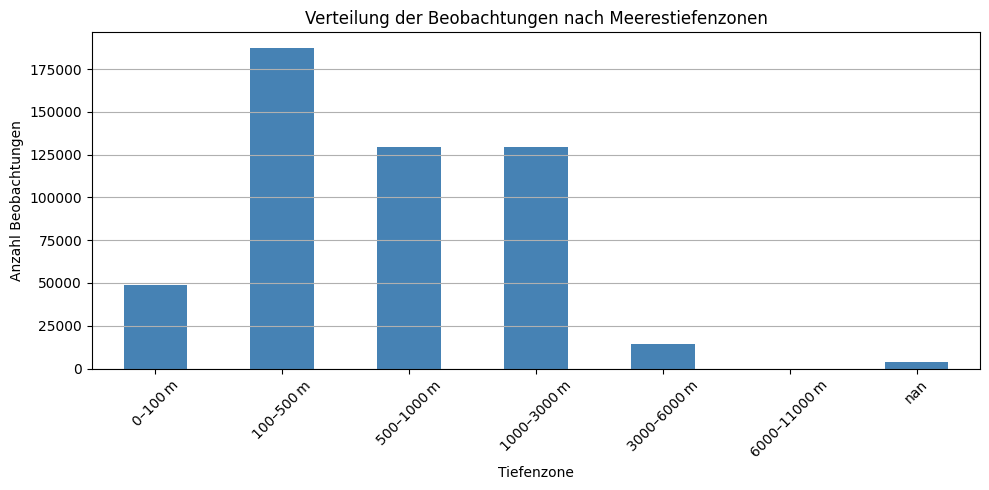

In [38]:
import matplotlib.pyplot as plt

# Zähle Vorkommen pro Zone
depth_zone_counts = df['DepthZone'].value_counts(dropna=False).sort_index()

# Balkendiagramm
plt.figure(figsize=(10, 5))
depth_zone_counts.plot(kind='bar', color='steelblue')
plt.title("Verteilung der Beobachtungen nach Meerestiefenzonen")
plt.xlabel("Tiefenzone")
plt.ylabel("Anzahl Beobachtungen")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#  Top 10 Arten

In [39]:
top_10_species = df['ScientificName'].value_counts().head(10)
plt.figure()
top_10_species.plot(kind='barh', color='steelblue')
plt.title("Top 10 Arten")
plt.xlabel("Beobachtungen")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("03_top_10_arten.png")
plt.close()


# Scatterplot – Tiefe vs. Art (Top 20)

In [40]:
top_20 = df['ScientificName'].value_counts().head(20).index
df_top = df[df['ScientificName'].isin(top_20)]

plt.figure(figsize=(12, 6))
sns.stripplot(data=df_top, x='DepthInMeters', y='ScientificName', alpha=0.4, jitter=True)
plt.title("Top 20 Arten nach Tiefe (Scatter)")
plt.tight_layout()
plt.savefig("04_top20_scatter.png")
plt.close()


# Boxplot – Tiefe nach Art (Top 20)

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top, y='ScientificName', x='DepthInMeters', hue='ScientificName', palette='Blues', dodge=False, legend=False)
plt.title("Verteilung der Tiefe – Top 20 Arten (Boxplot)")
plt.tight_layout()
plt.savefig("05_top20_boxplot.png")
plt.close()


# 16. Interaktive Karte mit Folium

In [42]:
m = folium.Map(location=[0, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(m)

sample_df = df[['latitude', 'longitude', 'ScientificName']].dropna().sample(n=1000, random_state=42)
for _, row in sample_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['ScientificName']).add_to(marker_cluster)

m.save("deep_sea_map.html")


# 17. Automatisierte PowerPoint-Erstellung

In [43]:
#prs = Presentation()

#slide = prs.slides.add_slide(prs.slide_layouts[0])
#slide.shapes.title.text = "Deep Sea Corals – Datenanalyse"
#slide.placeholders[1].text = "Dennis Maier – Abschlussprojekt 2025"

#def add_visual_slide(title, img_path):
    #slide = prs.slides.add_slide(prs.slide_layouts[5])
    #slide.shapes.title.text = title
    #slide.shapes.add_picture(img_path, Inches(0.8), Inches(1.2), width=Inches(8.2))

#add_visual_slide("Beobachtungen pro Jahr", "01_beobachtungen_pro_jahr.png")
#add_visual_slide("Tiefenzonen", "02_tiefenzonen.png")
#add_visual_slide("Top 10 Arten", "03_top_10_arten.png")
#add_visual_slide("Scatterplot", "04_top20_scatter.png")
#add_visual_slide("Boxplot", "05_top20_boxplot.png")

#prs.save("DeepSea_Praesentation_DennisMaier_FINAL.pptx")


# upload_to_mysql_corals.py

In [44]:
# upload_to_mysql_corals.py

#import pandas as pd
#from sqlalchemy import create_engine
#from sqlalchemy.exc import SQLAlchemyError
#import os

# === KONFIGURATION ===
#db_user = "root"
#db_password = ""  #  Achtung: Bei produktiven Projekten nicht hartkodieren!
#db_host = "localhost"
#db_name = "abschlussprojekt"
#table_name = "corals"

# === CSV-PFAD ===
#csv_path = r"C:\Users\denni\OneDrive\Dokumente\Abschlußprojekt\deep_sea_corals.csv"

# === PRÜFUNG ===
#if not os.path.isfile(csv_path):
    #raise FileNotFoundError(f" CSV-Datei nicht gefunden unter: {csv_path}")

# === VERBINDUNG AUFBAUEN ===
#engine = create_engine(
    #f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"
#)

# === DATEN EINLESEN ===
#try:
    #df = pd.read_csv(csv_path, encoding="utf-8", low_memory=False)
    #print(f" CSV geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")

    # === IN MYSQL ÜBERTRAGEN ===
    #df.to_sql(
        #name=table_name,
        #con=engine,
        #if_exists="replace",  # Alternativ: 'append'
        #index=False,
        #chunksize=1000        # in 1000er-Blöcken für große Daten
    #)

    #print(" Daten erfolgreich in die Datenbank geladen.")

#except SQLAlchemyError as e:
    #print(" Fehler beim SQL-Upload:", str(e))

#except Exception as e:
    #print(" Allgemeiner Fehler:", str(e))
